<a href="https://colab.research.google.com/github/edwardsanchez001/capstoneProject/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:


import matplotlib.pyplot as plt
import matplotlib as mpl
#from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import cm
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import re
from scipy.interpolate import interp1d

from scipy.stats import norm
import statsmodels.api as sm
import requests
from io import BytesIO
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import itertools
from statsmodels.tsa.stattools import acf


from fbprophet import Prophet

from sklearn.metrics import mean_squared_error as mse

from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Global % changes


In [ ]:
temperature_Change_Global = pd.read_csv('/content/drive/MyDrive/Ironhack/Final_Project/temperature-anomaly.csv')
#temperature_Change_Global

In [ ]:
temperature_Change_Global.rename(columns={'Median temperature anomaly from 1961-1990 average': 'Median Temperature Anomaly °C'}, inplace=True)
temperature_Change_Global = temperature_Change_Global[temperature_Change_Global['Entity']== 'Global']
temperature_Change_Global = temperature_Change_Global.drop(columns='Entity')
temperature_Change_Global = temperature_Change_Global.drop(columns='Upper bound (95% CI)')
temperature_Change_Global = temperature_Change_Global.drop(columns='Lower bound (95% CI)')
temperature_Change_Global = temperature_Change_Global.drop(columns='Code')

In [ ]:
#temperature_Change_Global.info()

In [ ]:
temperature_Change_Global = temperature_Change_Global.sort_values(by=["Year"], ascending=False)
temperature_Change_Global['Year'] = temperature_Change_Global['Year'].astype(str)
temperature_Change_Global['Year'] = temperature_Change_Global.apply(lambda x : x['Year']+'0101', axis=1 )
temperature_Change_Global['Year'] = temperature_Change_Global['Year'].astype(int)
temperature_Change_Global = temperature_Change_Global.set_index('Year')
temperature_Change_Global = temperature_Change_Global[temperature_Change_Global.index >= 1900]
temperature_Change_Global.index = pd.to_datetime(temperature_Change_Global.index, format='%Y%m%d', errors='ignore')

In [ ]:
dftest = adfuller(temperature_Change_Global['Median Temperature Anomaly °C'], autolag=None)
dftest

(-2.5987585035497016,
 0.09325413108681069,
 14,
 155,
 {'1%': -3.4732590518613002,
  '10%': -2.5768120811654525,
  '5%': -2.880374082105334})

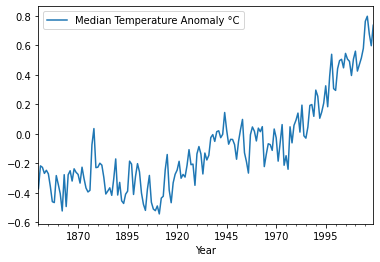

In [ ]:
temperature_Change_Global.plot()

<Figure size 720x576 with 0 Axes>

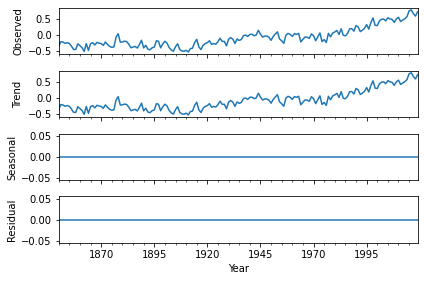

In [ ]:
fig = plt.figure(figsize=[10, 8])
decompsition = sm.tsa.seasonal_decompose(temperature_Change_Global['Median Temperature Anomaly °C'], model='additive')
fig = decompsition.plot()
plt.show()

In [ ]:
temperature_Change_Global = temperature_Change_Global[ temperature_Change_Global.index >= '1970-01-01']

In [ ]:
temperature_Change_Global.head()

,Median Temperature Anomaly °C
Year,
2019-01-01,0.736
2018-01-01,0.597
2017-01-01,0.677
2016-01-01,0.797
2015-01-01,0.763


In [ ]:
#model = ARIMA(temperature_Change_Global['Median Temperature Anomaly °C'] , order=(1,2,1))  
#results_TCG = model.fit(disp=0)
#results_TCG.plot_predict(dynamic=False)
#plt.show()

In [ ]:

# Create Training and Test
train = temperature_Change_Global[10:]
test = temperature_Change_Global[:10]
#Change Name for FB
#Chacking if it workes 
  #train= train.reset_index().rename(columns={'Year':'ds', 'Median Temperature Anomaly °C':'y'})  # rename necesario para Prophet
  #test= test.reset_index().rename(columns={'Year':'ds', 'Median Temperature Anomaly °C':'y'})
  #modelo=Prophet().fit(train)
  #pred=modelo.predict(test)
#Actual data
train_all= temperature_Change_Global.reset_index().rename(columns={'Year':'ds', 'Median Temperature Anomaly °C':'y'})  # rename necesario para Prophet
modelo_all=Prophet().fit(train_all)
#Forcasting
future = modelo_all.make_future_dataframe(periods=11, freq='YS')
forcast = modelo_all.predict(future)
#Only want certain dates
New_data = forcast[forcast['ds'] >= '2020']
#Rename
New_data.rename(columns={'ds':'Year'},inplace=True)
#Reseting index
New_data.set_index('Year', inplace=True)
#only want one column
data_temp = New_data['yhat']
#making into DF
data_temp = pd.DataFrame(data_temp)
#rename
data_temp.rename(columns={'yhat': 'Median Temperature Anomaly °C'}, inplace=True)
#flip it 
data_temp = data_temp.sort_index(ascending=False)
#set up for concat
data_temp.reset_index(inplace=True)
temperature_Change_Global.reset_index(inplace=True)
all_dfs = [data_temp, temperature_Change_Global]
#concat method
for df in all_dfs:
    df.columns = ['Year', 'Median Temperature Anomaly °C']

temperature_Change_Global_Predictions = pd.concat(all_dfs).reset_index(drop=True)
temperature_Change_Global_Predictions.set_index('Year', inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#fig = modelo_all.plot(forcast)

In [ ]:
#New_data

In [ ]:
plot_plotly(modelo_all, forcast)

In [ ]:
#New_data.head()

In [ ]:
#f, ax=plt.subplots(1)
#f.set_figheight(5)
#f.set_figwidth(15)
#ax.scatter(test.ds, test.y, color='r')
#fig=modelo.plot(pred, ax=ax)

In [ ]:
#ata_temp

In [ ]:
#temperature_Change_Global.head()

In [ ]:
temperature_Change_Global_Predictions.head()

,Median Temperature Anomaly °C
Year,
2030-01-01,0.902009
2029-01-01,0.893320
2028-01-01,0.828549
2027-01-01,0.834037
2026-01-01,0.832446


### California Drought Data

In [ ]:
california_drought = pd.read_csv('/content/drive/MyDrive/Ironhack/Project_Viz/CA.csv')
#california_drought.head()

In [ ]:
california_drought = california_drought.drop(columns='StatisticFormatID')
california_drought = california_drought.drop(columns='ValidStart')
california_drought = california_drought.drop(columns='ValidEnd')
california_drought = california_drought.drop(columns='None')
california_drought = california_drought.drop(columns='StateAbbreviation')
california_drought.rename(columns={'MapDate': 'Year'}, inplace=True)

In [ ]:
#california_drought.info()

In [ ]:
california_drought = california_drought.set_index('Year')
california_drought.replace(',','', regex=True, inplace=True)
california_drought = california_drought.astype(float)
california_drought.index = pd.to_datetime(california_drought.index, format='%Y%m%d', errors='ignore')
california_drought_Year = california_drought.resample('YS').mean()   # Year Start
california_drought_Year = california_drought_Year.sort_index(ascending=False)

In [ ]:
#california_drought_Year.index = pd.DatetimeIndex(california_drought_Year.index).year

In [ ]:
cols = ['D0', 'D1', 'D2', 'D3', 'D4']
california_drought_Year[cols] = california_drought_Year[cols].applymap(np.int64)

In [ ]:
#california_drought_Year.head()

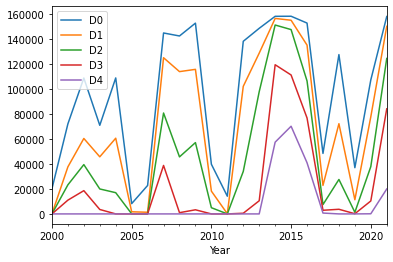

In [ ]:
california_drought_Year.plot()

<Figure size 720x576 with 0 Axes>

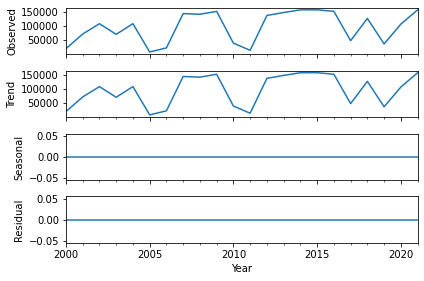

In [ ]:
fig = plt.figure(figsize=[10, 8])
decompsition = sm.tsa.seasonal_decompose(california_drought_Year['D0'], model='additive')
fig = decompsition.plot()
plt.show()

In [ ]:
D0 = pd.DataFrame(california_drought_Year['D0'])
D1 = pd.DataFrame(california_drought_Year['D1'])
D2 = pd.DataFrame(california_drought_Year['D2'])
D3 = pd.DataFrame(california_drought_Year['D3'])
D4 = pd.DataFrame(california_drought_Year['D4'])

In [ ]:
D0.head()

,D0
Year,
2021-01-01,157733
2020-01-01,107091
2019-01-01,36941
2018-01-01,127300
2017-01-01,48353


In [ ]:
D0.columns[0]

'D0'

In [ ]:
D0.iloc[:, 0]

Year
2021-01-01    157733
2020-01-01    107091
2019-01-01     36941
2018-01-01    127300
2017-01-01     48353
2016-01-01    152489
2015-01-01    157948
2014-01-01    157885
2013-01-01    148304
2012-01-01    137929
2011-01-01     14158
2010-01-01     39692
2009-01-01    152439
2008-01-01    142181
2007-01-01    144576
2006-01-01     22723
2005-01-01      8222
2004-01-01    108654
2003-01-01     70802
2002-01-01    108592
2001-01-01     71942
2000-01-01     20107
Freq: -1AS-JAN, Name: D0, dtype: int64

In [ ]:
all_col = [D0, D1, D2, D3, D4]

In [ ]:

#Changing the names to fit FB Prophit
train_all= D0.reset_index().rename(columns={'Year':'ds', 'D0':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'D0'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
D0.reset_index(inplace=True)
all_dfs = [data_temp, D0]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'D0']

D0_Prediction = pd.concat(all_dfs).reset_index(drop=True)
D0_Prediction.set_index('Year', inplace=True)
#done
D0_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,D0
Year,
2030-01-01,153255.027640
2029-01-01,146302.624495
2028-01-01,156033.826948
2027-01-01,148507.878166
2026-01-01,141266.129987


In [ ]:

#Changing the names to fit FB Prophit
train_all= D1.reset_index().rename(columns={'Year':'ds', 'D1':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'D1'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
D1.reset_index(inplace=True)
all_dfs = [data_temp, D1]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'D1']

D1_Prediction = pd.concat(all_dfs).reset_index(drop=True)
D1_Prediction.set_index('Year', inplace=True)
#done
D1_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,D1
Year,
2030-01-01,137683.947831
2029-01-01,131609.351234
2028-01-01,136852.629525
2027-01-01,130266.728364
2026-01-01,123934.717533


In [ ]:

#Changing the names to fit FB Prophit
train_all= D2.reset_index().rename(columns={'Year':'ds', 'D2':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'D2'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
D2.reset_index(inplace=True)
all_dfs = [data_temp, D2]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'D2']

D2_Prediction = pd.concat(all_dfs).reset_index(drop=True)
D2_Prediction.set_index('Year', inplace=True)
#done
D2_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,D2
Year,
2030-01-01,106687.412034
2029-01-01,106012.292333
2028-01-01,95807.060450
2027-01-01,95215.424599
2026-01-01,94583.497489


In [ ]:

#Changing the names to fit FB Prophit
train_all= D3.reset_index().rename(columns={'Year':'ds', 'D3':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'D3'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
D3.reset_index(inplace=True)
all_dfs = [data_temp, D3]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'D3']

D3_Prediction = pd.concat(all_dfs).reset_index(drop=True)
D3_Prediction.set_index('Year', inplace=True)
#done
D3_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,D3
Year,
2030-01-01,65892.661195
2029-01-01,63863.565745
2028-01-01,60182.192575
2027-01-01,58798.942312
2026-01-01,57093.068384


In [ ]:

#Changing the names to fit FB Prophit
train_all= D4.reset_index().rename(columns={'Year':'ds', 'D4':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'D4'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
D4.reset_index(inplace=True)
all_dfs = [data_temp, D4]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'D4']

D4_Prediction = pd.concat(all_dfs).reset_index(drop=True)
D4_Prediction.set_index('Year', inplace=True)
#done
D4_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,D4
Year,
2030-01-01,29407.833575
2029-01-01,26635.404325
2028-01-01,29920.456377
2027-01-01,27580.512178
2026-01-01,25023.436228


In [ ]:
Drought_Preditions = D0_Prediction.join(D1_Prediction)
Drought_Preditions = Drought_Preditions.join(D2_Prediction)
Drought_Preditions = Drought_Preditions.join(D3_Prediction)
Drought_Preditions = Drought_Preditions.join(D4_Prediction)

In [ ]:
Drought_Preditions = Drought_Preditions.sort_values(by=["Year"], ascending=False)


In [ ]:
print(Drought_Preditions)

                       D0             D1  ...            D3            D4
Year                                      ...                            
2030-01-01  153255.027640  137683.947831  ...  65892.661195  29407.833575
2029-01-01  146302.624495  131609.351234  ...  63863.565745  26635.404325
2028-01-01  156033.826948  136852.629525  ...  60182.192575  29920.456377
2027-01-01  148507.878166  130266.728364  ...  58798.942312  27580.512178
2026-01-01  141266.129987  123934.717533  ...  57093.068384  25023.436228
...                   ...            ...  ...           ...           ...
2004-01-01  108654.000000   60490.000000  ...      0.000000      0.000000
2003-01-01   70802.000000   45633.000000  ...   3545.000000      0.000000
2002-01-01  108592.000000   60291.000000  ...  18589.000000      0.000000
2001-01-01   71942.000000   37599.000000  ...  11006.000000      0.000000
2000-01-01   20107.000000      84.000000  ...      0.000000      0.000000

[124 rows x 5 columns]


### California Annual Average Temerature

In [ ]:
california_temp = pd.read_csv('/content/drive/MyDrive/Ironhack/Final_Project/Cali_Temp_Clean - Sheet2-2.csv')
california_temp.head()

,Year,Temp,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,2021,Avg.,59.0,60.5,59.5,64.6,66.3,71.1,75.0,---,---,---,---,---,---
1,2020,Avg.,60.9,62.6,61.3,66.6,70.5,71.3,72.2,76.7,76.2,73,62.8,60,67.8
2,2019,Avg.,57.9,54.0,61.1,65.2,63.3,69.3,74.4,75.5,76.6,72.2,64.9,59.4,66.1
3,2018,Avg.,62.2,59.4,60.1,64.4,64.9,70.1,78.8,78.3,73.4,70.5,65.1,58.9,67.2
4,2017,Avg.,57.1,59.8,65.5,67.8,67.1,71.4,76.4,76.6,75.2,74.1,66.4,61,68.2


In [ ]:
california_temp['Year'] = california_temp['Year'].astype(str)
california_temp['Year'] = california_temp.apply(lambda x : x['Year']+'0101', axis=1 )
california_temp['Year'] = california_temp['Year'].astype(int)
california_temp = california_temp.set_index('Year')
california_temp_annual = california_temp.drop(columns={'Temp','Jan',	'Feb',	'Mar',	'Apr',	'May',	'Jun',	'Jul',	'Aug',	'Sep',	'Oct',	'Nov',	'Dec' })

In [ ]:
#california_temp.head()

In [ ]:
california_temp_annual = california_temp_annual.iloc[1: , :]

In [ ]:
#california_temp_annual.at[20210101,'Annual']= 0

In [ ]:
#california_temp_annual.at[2021,'Annual']= 'NaN'

In [ ]:
#california_temp_annual.fillna(method='pad', inplace=True)

In [ ]:
#california_temp_annual = california_temp_annual.interpolate(method ='linear', limit_direction ='backward', limit = 1)

In [ ]:
california_temp_annual = california_temp_annual.astype(float)
california_temp_annual['Celcius'] = california_temp_annual.apply(lambda x : (x['Annual']-32)*(5/9), axis=1 )
california_temp_annual.drop(columns='Annual', inplace=True)
california_temp_annual.rename(columns={'Celcius': 'Annual Average °C'}, inplace=True)

In [ ]:
#california_temp_annual.info()

In [ ]:
california_temp_annual = california_temp_annual.round(2)
california_temp_annual = california_temp_annual[california_temp_annual.index >= 1900]

In [ ]:
dftest = adfuller(california_temp_annual['Annual Average °C'], autolag=None)
dftest

(-0.8242266549832589,
 0.8119018916041719,
 14,
 126,
 {'1%': -3.4833462346078936,
  '10%': -2.5791564575459813,
  '5%': -2.8847655969877666})

In [ ]:
#.77 p value 
#not stationary. 
#STARIMAX is needed because its not stational. 

In [ ]:
california_temp_annual.index = pd.to_datetime(california_temp_annual.index, format='%Y%m%d', errors='ignore')

In [ ]:
#california_temp_annual.head()

In [ ]:
#california_temp_annual.info()

<Figure size 720x576 with 0 Axes>

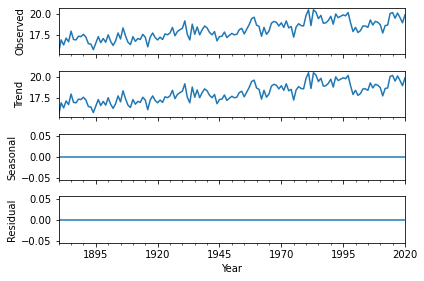

In [ ]:
fig = plt.figure(figsize=[10, 8])
decompsition = sm.tsa.seasonal_decompose(california_temp_annual['Annual Average °C'], model='additive')
fig = decompsition.plot()
plt.show()

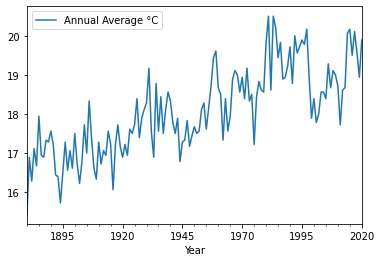

In [ ]:
california_temp_annual.plot()

In [ ]:
cali_temp_export = california_temp_annual

In [ ]:
california_temp_annual = california_temp_annual[ california_temp_annual.index >= '1971-01-01']

In [ ]:
print(len(california_temp_annual))

50


In [ ]:
california_temp_annual.head()

,Annual Average °C
Year,
2020-01-01,19.89
2019-01-01,18.94
2018-01-01,19.56
2017-01-01,20.11
2016-01-01,19.50


In [ ]:
#california_temp_annual.info


In [ ]:
# Create Training and Test
train = california_temp_annual[10:]
test = california_temp_annual[:10]
#Changing the names to fit FB Prophit
train_all= california_temp_annual.reset_index().rename(columns={'Year':'ds', 'Annual Average °C':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=10, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2021']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'Annual Average °C'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
california_temp_annual.reset_index(inplace=True)
all_dfs = [data_temp, california_temp_annual]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'Annual Average °C']

california_temp_annual_Prediction = pd.concat(all_dfs).reset_index(drop=True)
california_temp_annual_Prediction.set_index('Year', inplace=True)
#done
california_temp_annual_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Annual Average °C
Year,
2030-01-01,19.112650
2029-01-01,19.319292
2028-01-01,19.306126
2027-01-01,19.099811
2026-01-01,19.100029


### CO2 Emitions

In [ ]:
CO2 = pd.read_csv('/content/drive/MyDrive/Ironhack/Final_Project/co2-concentration-long-term.csv')
CO2.head()

,Entity,Code,Year,"CO2 concentrations (NOAA, 2018)"
0,World,OWID_WRL,-803719,207.29
1,World,OWID_WRL,-803182,202.23
2,World,OWID_WRL,-802573,204.86
3,World,OWID_WRL,-802060,207.50
4,World,OWID_WRL,-801975,202.92


In [ ]:
CO2 = CO2.drop(columns={'Entity', 'Code'})

In [ ]:
CO2.rename(columns={'CO2 concentrations (NOAA, 2018)': 'CO2 Concentrations'}, inplace=True)

In [ ]:
CO2 = CO2[CO2['Year'] >= 1900]
CO2['Year'] = CO2['Year'].astype(str)
CO2['Year'] = CO2.apply(lambda x : x['Year']+'0101', axis=1 )
CO2['Year'] = CO2['Year'].astype(int)
CO2 = CO2.set_index('Year')
CO2.index = pd.to_datetime(CO2.index, format='%Y%m%d', errors='ignore')
CO2= CO2.sort_index(ascending=False) 


In [ ]:
#CO2.head()

In [ ]:
#CO2.info()

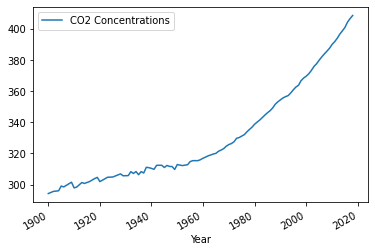

In [ ]:
CO2.plot()

<Figure size 720x576 with 0 Axes>

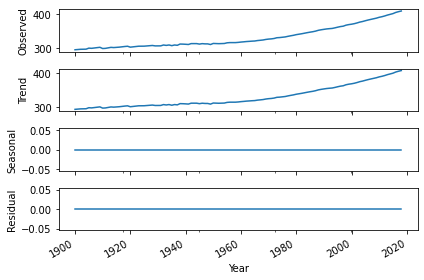

In [ ]:
fig = plt.figure(figsize=[10, 8])
decompsition = sm.tsa.seasonal_decompose(CO2['CO2 Concentrations'], model='additive', freq=1)
fig = decompsition.plot()
plt.show()

In [ ]:
 CO2 = CO2[CO2.index >= '1969-01-01']

In [ ]:
print(len(CO2))

50


In [ ]:
# Create Training and Test
train = CO2[10:]
test = CO2[:10]
#Changing the names to fit FB Prophit
train_all= CO2.reset_index().rename(columns={'Year':'ds', 'CO2 Concentrations':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=12, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'CO2 Concentrations'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
CO2.reset_index(inplace=True)
all_dfs = [data_temp, CO2]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'CO2 Concentrations']

CO2_Prediction = pd.concat(all_dfs).reset_index(drop=True)
CO2_Prediction.set_index('Year', inplace=True)
#done
CO2_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CO2 Concentrations
Year,
2030-01-01,436.161328
2029-01-01,433.821964
2028-01-01,431.497367
2027-01-01,429.191116
2026-01-01,426.889434


### Average Rain fall Per year


In [ ]:
rain = pd.read_csv('/content/drive/MyDrive/Ironhack/Final_Project/Average Rainfall in the wet seasons California. - Sheet1.csv')

In [ ]:
rain.head()

,Season (July 1-June 30),Total Inches of Rainfall,Inches Above/Below (+/-)\nOverall Season Average*
0,2021,5.82,-8.85
1,2020,14.86,0.19
2,2019,18.82,4.15
3,2018,4.79,-9.88
4,2017,19.00,4.33


In [ ]:

rain.rename(columns={'Season (July 1-June 30)':'Year'},inplace=True)
rain['Year'] = rain['Year'].astype(str)
rain['Year'] = rain.apply(lambda x : x['Year']+'0101', axis=1 )
rain['Year'] = rain['Year'].astype(int)
rain.set_index('Year',inplace=True)

In [ ]:
#rain.rename(columns={'Inches Above/Below (+/-)\nOverall Season Average*':'Change'},inplace=True)

In [ ]:
rain.drop(columns='Inches Above/Below (+/-)\nOverall Season Average*', inplace=True)

In [ ]:
rain.index = pd.to_datetime(rain.index, format='%Y%m%d', errors='ignore')

In [ ]:

#Changing the names to fit FB Prophit
train_all= rain.reset_index().rename(columns={'Year':'ds', 'Total Inches of Rainfall':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=9, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2019']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'Total Inches of Rainfall'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
rain.reset_index(inplace=True)
all_dfs = [data_temp, rain]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'Total Inches of Rainfall']

Rain_Prediction = pd.concat(all_dfs).reset_index(drop=True)
Rain_Prediction.set_index('Year', inplace=True)
#done
Rain_Prediction.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total Inches of Rainfall
Year,
2030-01-01,11.719462
2029-01-01,12.377581
2028-01-01,10.627689
2027-01-01,11.350929
2026-01-01,12.041968


In [ ]:
Rain_Prediction.head()

,Total Inches of Rainfall
Year,
2030-01-01,11.719462
2029-01-01,12.377581
2028-01-01,10.627689
2027-01-01,11.350929
2026-01-01,12.041968


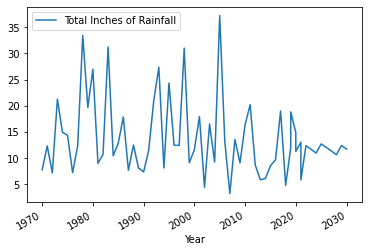

In [ ]:
Rain_Prediction.plot()

### Almond price per year in Cali

In [ ]:
almonds = pd.read_csv('/content/drive/MyDrive/Ironhack/Final_Project/Almond Prices and production - Sheet1.csv')

In [ ]:
almonds['Year'] = almonds['Year'].astype(str)
almonds['Year'] = almonds.apply(lambda x : x['Year']+'0101', axis=1 )
almonds = almonds.sort_index(ascending=False)
almonds['Year'] = almonds['Year'].astype(int)
almonds.set_index('Year', inplace=True)
almonds.index = pd.to_datetime(almonds.index, format='%Y%m%d', errors='ignore')

In [ ]:
almonds.head()

,Production millon pounds,Price per pound,Price Per Pound
Year,,,
2020-01-01,3115,1.83,5619930
2019-01-01,2560,2.45,6169100
2018-01-01,2280,2.50,5602500
2017-01-01,2270,2.53,5603950
2016-01-01,2140,2.39,5052460


In [ ]:
almonds.rename(columns={'Price Per Pound': 'Revenue Total'}, inplace=True)

In [ ]:
almonds.index = pd.to_datetime(almonds.index)

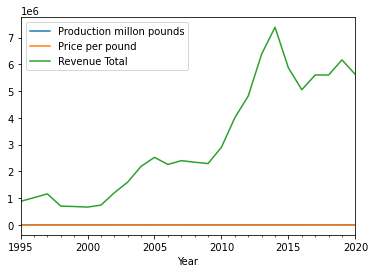

In [ ]:
almonds.plot()

In [ ]:
almond_price = almonds['Price per pound']
almond_production = almonds['Production millon pounds']
almond_revenue = almonds['Revenue Total']

In [ ]:
#Changing the names to fit FB Prophit
train_all= almond_price.reset_index().rename(columns={'Year':'ds', 'Price per pound':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=10, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2021']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'Price per pound'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
almond_price = pd.DataFrame(almond_price)
almond_price.reset_index(inplace=True)
all_dfs = [data_temp, almond_price]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'Price per pound']

almonds_price_Prediction = pd.concat(all_dfs).reset_index(drop=True)
almonds_price_Prediction.set_index('Year', inplace=True)
#done
almonds_price_Prediction.head()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Price per pound
Year,
2030-01-01,3.304312
2029-01-01,3.320884
2028-01-01,3.035243
2027-01-01,3.066024
2026-01-01,3.089748


In [ ]:
#Changing the names to fit FB Prophit
train_all= almond_revenue.reset_index().rename(columns={'Year':'ds', 'Revenue Total':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=10, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2021']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'Revenue Total'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
almond_revenue = pd.DataFrame(almond_revenue)
almond_revenue.reset_index(inplace=True)
all_dfs = [data_temp, almond_revenue]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'Revenue Total']

almond_revenue_Prediction = pd.concat(all_dfs).reset_index(drop=True)
almond_revenue_Prediction.set_index('Year', inplace=True)
#done
almond_revenue_Prediction.head()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Revenue Total
Year,
2030-01-01,9.114915e+06
2029-01-01,8.918605e+06
2028-01-01,8.406925e+06
2027-01-01,8.245074e+06
2026-01-01,8.066043e+06


In [ ]:
#Changing the names to fit FB Prophit
train_all= almond_production.reset_index().rename(columns={'Year':'ds', 'Production millon pounds':'y'})  # rename necesario para Prophet
#Putting it in a model
modelo_all=Prophet().fit(train_all)
train_all.head()
#Forcating 
future = modelo_all.make_future_dataframe(periods=10, freq='YS')
forcast = modelo_all.predict(future)
#Get only needed data 
New_data = forcast[forcast['ds'] >= '2021']
#Change the name back
New_data.rename(columns={'ds':'Year'},inplace=True)
#set index
New_data.set_index('Year', inplace=True)
#Only get the columns you need
data_temp = New_data['yhat']
data_temp = pd.DataFrame(data_temp)
#rename again.
data_temp.rename(columns={'yhat': 'Production millon pounds'}, inplace=True)
#flip the order
data_temp = data_temp.sort_index(ascending=False)
#Reset indexes so i can concat
data_temp.reset_index(inplace=True)
almond_production = pd.DataFrame(almond_production)
almond_production.reset_index(inplace=True)
all_dfs = [data_temp, almond_production]
#function to concat and add index again. 
for df in all_dfs:
    df.columns = ['Year', 'Production millon pounds']

almond_production_Prediction = pd.concat(all_dfs).reset_index(drop=True)
almond_production_Prediction.set_index('Year', inplace=True)
#done
almond_production_Prediction.head()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Production millon pounds
Year,
2030-01-01,3449.624391
2029-01-01,3327.499875
2028-01-01,3375.943740
2027-01-01,3225.348232
2026-01-01,3088.957516


In [ ]:
almonds_Prediction = almond_production_Prediction.join(almonds_price_Prediction)
almonds_Prediction = almonds_Prediction.join(almond_revenue_Prediction)


### Combine the data

In [ ]:
California_total = temperature_Change_Global_Predictions.join(california_temp_annual_Prediction)
California_total.head()

,Median Temperature Anomaly °C,Annual Average °C
Year,,
2030-01-01,0.902009,19.112650
2029-01-01,0.893320,19.319292
2028-01-01,0.828549,19.306126
2027-01-01,0.834037,19.099811
2026-01-01,0.832446,19.100029


In [ ]:
California_total = California_total.join(CO2_Prediction)
California_total.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations
Year,,,
2030-01-01,0.902009,19.112650,436.161328
2029-01-01,0.893320,19.319292,433.821964
2028-01-01,0.828549,19.306126,431.497367
2027-01-01,0.834037,19.099811,429.191116
2026-01-01,0.832446,19.100029,426.889434


In [ ]:
California_total = California_total.join(Rain_Prediction)
California_total.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall
Year,,,,
1970-01-01,-0.027,NaN,325.68,7.77
1971-01-01,-0.186,18.39,326.32,12.32
1972-01-01,-0.065,19.17,327.45,7.17
1973-01-01,0.062,18.33,329.68,21.26
1974-01-01,-0.214,18.50,330.18,14.92


In [ ]:
 California_total = California_total.join(almonds_Prediction)
California_total.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall,Production millon pounds,Price per pound,Revenue Total
Year,,,,,,,
1970-01-01,-0.027,NaN,325.68,7.77,NaN,NaN,NaN
1971-01-01,-0.186,18.39,326.32,12.32,NaN,NaN,NaN
1972-01-01,-0.065,19.17,327.45,7.17,NaN,NaN,NaN
1973-01-01,0.062,18.33,329.68,21.26,NaN,NaN,NaN
1974-01-01,-0.214,18.50,330.18,14.92,NaN,NaN,NaN


In [ ]:
California_total = California_total.join(Drought_Preditions)
California_total.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4
Year,,,,,,,,,,,,
1970-01-01,-0.027,NaN,325.68,7.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-01,-0.186,18.39,326.32,12.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-01-01,-0.065,19.17,327.45,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-01,0.062,18.33,329.68,21.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-01-01,-0.214,18.50,330.18,14.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
California_total = California_total[California_total.index >= '2000-01-01']

In [ ]:
California_total = California_total.round(2)

In [ ]:
California_total = California_total.sort_values(by=["Year"], ascending=False)


In [ ]:
California_total = California_total.groupby(California_total.index.date).mean()


In [ ]:
California_total.index.name ='Year'

In [ ]:
California_total = California_total.sort_index(ascending=False)


In [ ]:
California_total.reset_index(inplace=True)

In [ ]:
California_total.head()

,Year,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4
0,2030-01-01,0.90,19.11,436.16,11.72,3449.62,3.30,9114914.56,153255.03,137683.95,106687.41,65892.66,29407.83
1,2029-01-01,0.89,19.32,433.82,12.38,3327.50,3.32,8918604.87,146302.62,131609.35,106012.29,63863.57,26635.40
2,2028-01-01,0.83,19.31,431.50,10.63,3375.94,3.04,8406925.03,156033.83,136852.63,95807.06,60182.19,29920.46
3,2027-01-01,0.83,19.10,429.19,11.35,3225.35,3.07,8245073.98,148507.88,130266.73,95215.42,58798.94,27580.51
4,2026-01-01,0.83,19.10,426.89,12.04,3088.96,3.09,8066043.31,141266.13,123934.72,94583.50,57093.07,25023.44


In [ ]:
California_total['Year'] = California_total['Year'].astype(str)
California_total_2021 = California_total[California_total['Year'] <= '2021-01-01']
California_total_2021.set_index('Year', inplace=True)
California_total_2021.index = pd.to_datetime(California_total_2021.index)
California_total_2021.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4
Year,,,,,,,,,,,,
2021-01-01,0.75,19.29,415.28,9.420,2606.17,2.89,6820862.36,140028.915,126997.945,103018.230,65109.190,18892.805
2020-01-01,0.69,19.89,412.95,13.065,3115.00,1.83,5619930.00,119573.515,93488.585,54705.115,26464.005,10629.830
2019-01-01,0.74,18.94,410.65,15.410,2560.00,2.45,6169100.00,80735.540,57044.635,36160.300,20675.380,9405.860
2018-01-01,0.60,19.56,408.52,4.790,2280.00,2.50,5602500.00,127300.000,72092.000,27533.000,3708.000,0.000
2017-01-01,0.68,20.11,406.55,19.000,2270.00,2.53,5603950.00,48353.000,22777.000,7467.000,2912.000,686.000


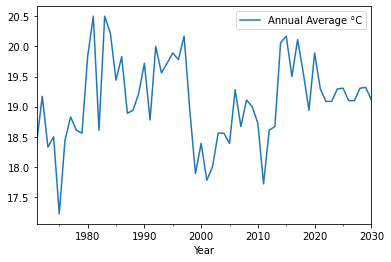

In [ ]:
california_temp_annual_Prediction.plot()

### Future predictions


In [ ]:
"""
#cols = ['Median Temperature Anomaly °C','Annual Average °C','CO2 Concentrations','D0','D1','D2','D3','D4', 'Total Inches of Rainfall']
California_total.reset_index(inplace=True)
results = []
for col in cols:
    subdf = California_total[['Year', col]].dropna()
    subdf = subdf.rename(columns={'Year':'ds', col:'y'})
    m = Prophet()
    m.fit(subdf)
    result = m.predict(m.make_future_dataframe(periods = 9, freq='YS'))

    forcast = modelo_all.predict(future)
    #Get only needed data 
    New_data = forcast[forcast['ds'] >= '2019']
    #Change the name back
    New_data.rename(columns={'ds':'Year'},inplace=True)
    #set index
    New_data.set_index('Year', inplace=True)
    #Only get the columns you need  
    data_temp = New_data['yhat']
    data_temp = pd.DataFrame(data_temp)
    #rename again.
    data_temp.rename(columns={'yhat': 'CO2 Concentrations'}, inplace=True)
    #flip the order
    data_temp = data_temp.sort_index(ascending=False)
    #Reset indexes so i can concat
    data_temp.reset_index(inplace=True)
    CO2.reset_index(inplace=True)
    all_dfs = [data_temp, CO2]
    #function to concat and add index again. 
    for df in all_dfs:
        df.columns = ['Year', 'CO2 Concentrations']

    CO2_Prediction = pd.concat(all_dfs).reset_index(drop=True)
    CO2_Prediction.set_index('Year', inplace=True)
    #done
    CO2_Prediction.head()

    results.append(result)

California_total.predict = pd.concat(results, axis=1)
"""

"\n#cols = ['Median Temperature Anomaly °C','Annual Average °C','CO2 Concentrations','D0','D1','D2','D3','D4', 'Total Inches of Rainfall']\nCalifornia_total.reset_index(inplace=True)\nresults = []\nfor col in cols:\n    subdf = California_total[['Year', col]].dropna()\n    subdf = subdf.rename(columns={'Year':'ds', col:'y'})\n    m = Prophet()\n    m.fit(subdf)\n    result = m.predict(m.make_future_dataframe(periods = 9, freq='YS'))\n\n    forcast = modelo_all.predict(future)\n    #Get only needed data \n    New_data = forcast[forcast['ds'] >= '2019']\n    #Change the name back\n    New_data.rename(columns={'ds':'Year'},inplace=True)\n    #set index\n    New_data.set_index('Year', inplace=True)\n    #Only get the columns you need  \n    data_temp = New_data['yhat']\n    data_temp = pd.DataFrame(data_temp)\n    #rename again.\n    data_temp.rename(columns={'yhat': 'CO2 Concentrations'}, inplace=True)\n    #flip the order\n    data_temp = data_temp.sort_index(ascending=False)\n    #Reset

In [ ]:
#results

### Correlations

In [ ]:
#California_total_2021_Standard[''] = StandardScaler().fit_transform(
 #                           California_total_2021.values.reshape(-1, 1))

In [ ]:
#California_total_2021_Standard[:10]

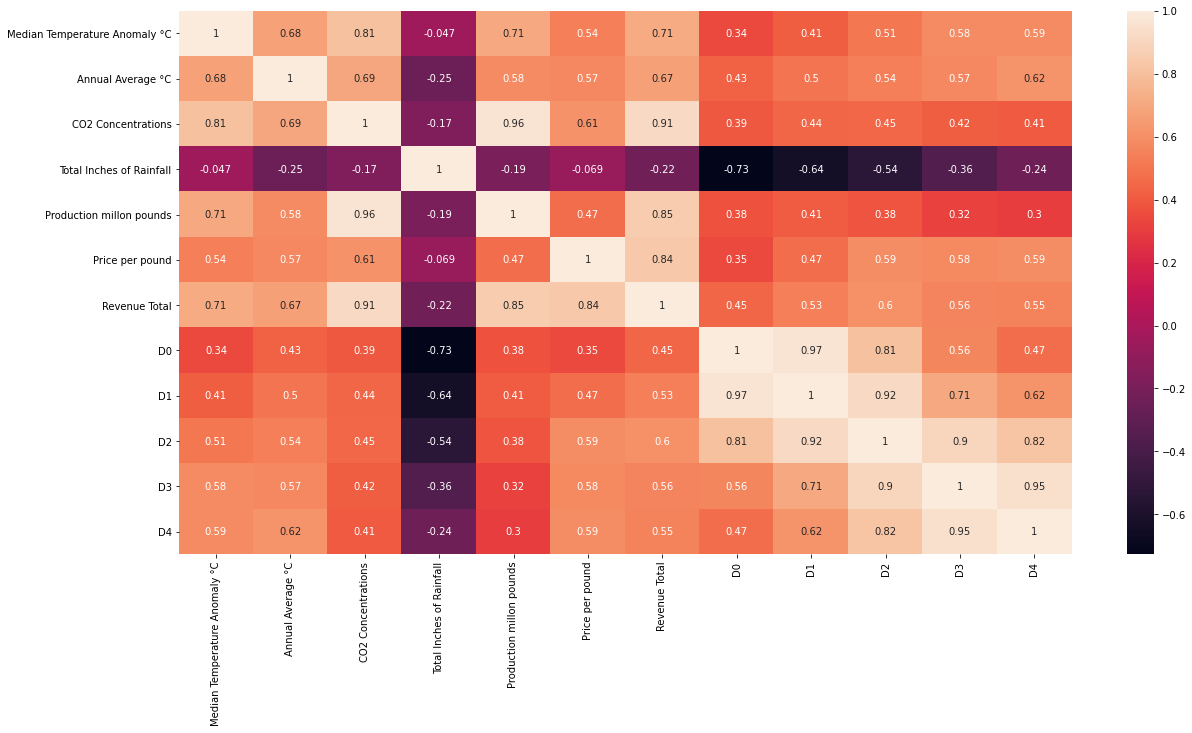

In [ ]:
plt.subplots(figsize=(20, 10))
sns.heatmap(California_total_2021.corr(), annot=True)

In [ ]:
#sns.pairplot(California_total)

### Standardized Data

In [ ]:
col_names = ['Median Temperature Anomaly °C','Annual Average °C','CO2 Concentrations','Production millon pounds', 'Price per pound','Revenue Total','D0','D1','D2','D3','D4', 'Total Inches of Rainfall']
features = California_total_2021[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4,Total Inches of Rainfall
0,1.504822,0.477479,1.702643,1.420695,0.949141,1.431020,0.794798,1.016810,1.200801,1.172736,0.481588,-0.412738
1,1.042876,1.329199,1.535047,2.220211,-0.451743,0.854683,0.400015,0.373819,0.149164,0.088343,0.060218,0.090914
2,1.427831,-0.019357,1.369608,1.348149,0.367642,1.118234,-0.349545,-0.325482,-0.254503,-0.074087,-0.002199,0.414936
3,0.349959,0.860753,1.216398,0.908190,0.433721,0.846319,0.549134,-0.036747,-0.442294,-0.550195,-0.481851,-1.052493
4,0.965886,1.641497,1.074696,0.892477,0.473369,0.847014,-0.974518,-0.983022,-0.879073,-0.572531,-0.446868,0.910988


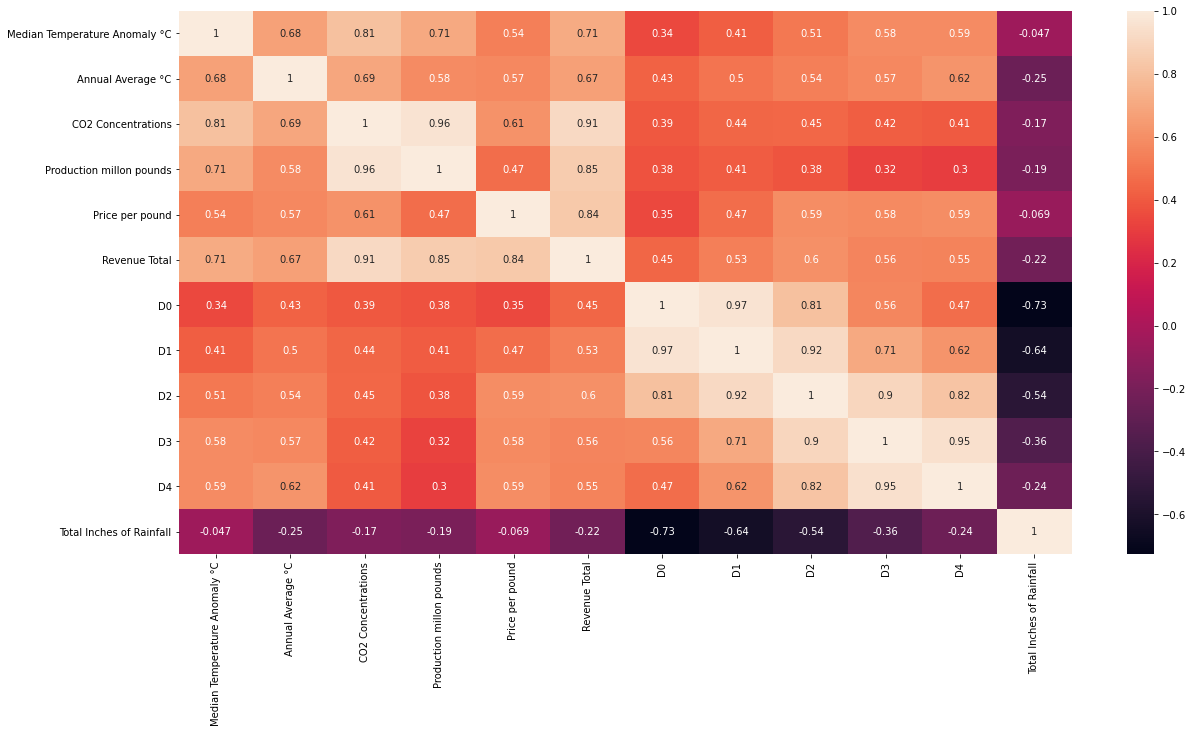

In [ ]:
plt.subplots(figsize=(20, 10))
sns.heatmap(scaled_features.corr(), annot=True)
plt.savefig('/content/drive/MyDrive/Ironhack/Final_Project/heatmap')

In [ ]:
#sns.pairplot(scaled_features)


In [ ]:
California_total_2021.reset_index(inplace=True)
year_col = California_total_2021['Year']
year_col = pd.DataFrame(year_col)
scaled_features = year_col.join(scaled_features)
scaled_features.set_index('Year', inplace=True)

In [ ]:
scaled_features.tail()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4,Total Inches of Rainfall
Year,,,,,,,,,,,,
2004-01-01,-0.804905,-0.558780,-1.013425,-1.095197,0.050461,-0.791844,0.189272,-0.259371,-0.672351,-0.654243,-0.481851,-0.437610
2003-01-01,-0.419950,-0.558780,-1.137144,-1.040202,-0.795356,-1.074443,-0.541259,-0.544452,-0.607507,-0.554769,-0.481851,0.564166
2002-01-01,-0.419950,-1.353719,-1.318407,-0.961637,-1.403287,-1.266146,0.188075,-0.263189,-0.184028,-0.132631,-0.481851,-1.103618
2001-01-01,-0.881896,-1.666016,-1.472337,-1.370171,-1.667604,-1.487228,-0.519258,-0.698612,-0.535849,-0.345412,-0.481851,0.764522
2000-01-01,-2.036759,-0.800101,-1.586705,-1.569724,-1.588309,-1.522513,-1.519657,-1.418465,-1.041608,-0.654243,-0.481851,-0.115660


### Regression Test

In [ ]:
scaled_features.reset_index(inplace=True)


In [ ]:
scaled_features.set_index('Year', inplace=True)

In [ ]:
California_total_2021.set_index('Year', inplace=True)

In [ ]:
X = scaled_features.drop(columns={'Price per pound','Total Inches of Rainfall','D0', 'CO2 Concentrations'})
X2 = scaled_features.drop(columns={'Median Temperature Anomaly °C','Annual Average °C', 'CO2 Concentrations','Price per pound','Production millon pounds','D1','D2','D3','D4','Total Inches of Rainfall','D0'})
Y = California_total_2021.drop(columns={'Median Temperature Anomaly °C','Annual Average °C', 'CO2 Concentrations', 'Production millon pounds','Revenue Total','D1','D2','D3','D4','Total Inches of Rainfall','D0'})
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.2,
                                                    train_size=0.8, 
                                                    random_state=42)

model = LinearRegression()

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
r2_score(y_pred, Y_test)

0.7717506616769709

In [ ]:
Y.head()

,Price per pound
Year,
2021-01-01,2.89
2020-01-01,1.83
2019-01-01,2.45
2018-01-01,2.50
2017-01-01,2.53


In [ ]:
X2.head()

,Revenue Total
Year,
2021-01-01,1.431020
2020-01-01,0.854683
2019-01-01,1.118234
2018-01-01,0.846319
2017-01-01,0.847014


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(17, 8)
(5, 8)
(17, 1)
(5, 1)


In [ ]:
California_total['Year'] = California_total['Year'].astype(str)
California_total_2030 = California_total[California_total['Year'] >= '2021-01-01']
California_total_2030.set_index('Year', inplace=True)
California_total_2030.index = pd.to_datetime(California_total_2030.index)

In [ ]:
col_names = ['Median Temperature Anomaly °C','Annual Average °C','CO2 Concentrations','Production millon pounds', 'Price per pound','Revenue Total','D0','D1','D2','D3','D4', 'Total Inches of Rainfall']
features = California_total_2030[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features_2030 = pd.DataFrame(features, columns = col_names)

In [ ]:
California_total_2030.reset_index(inplace=True)
year_col = California_total_2030['Year']
year_col = pd.DataFrame(year_col)
scaled_features_2030 = year_col.join(scaled_features_2030)
scaled_features_2030.set_index('Year', inplace=True)
scaled_features_2030.head()

,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4,Total Inches of Rainfall
Year,,,,,,,,,,,,
2030-01-01,1.680238,-0.879360,1.568773,1.437964,1.552954,1.614341,1.292608,1.434357,1.415638,1.383222,1.297270,0.211957
2029-01-01,1.487107,1.149933,1.217286,0.981562,1.671049,1.353199,0.420117,0.719155,1.337522,1.046074,0.497950,0.918482
2028-01-01,0.328322,1.053300,0.868803,1.162598,0.017714,0.672533,1.641332,1.336481,0.156713,0.434384,1.445066,-0.954879
2027-01-01,0.328322,-0.975993,0.521823,0.599795,0.194857,0.457230,0.696866,0.561079,0.088257,0.204546,0.770435,-0.184125
2026-01-01,0.328322,-0.975993,0.176344,0.090062,0.312953,0.219073,-0.211935,-0.184430,0.015140,-0.078897,0.033206,0.554515


In [ ]:
X_2030 = scaled_features_2030.drop(columns={'Price per pound','Total Inches of Rainfall','D0', 'CO2 Concentrations'})
X2_2030 = scaled_features_2030.drop(columns={'Median Temperature Anomaly °C','Annual Average °C', 'CO2 Concentrations','Price per pound','Production millon pounds','D1','D2','D3','D4','Total Inches of Rainfall','D0'})
Y_2030 = scaled_features_2030.drop(columns={'Median Temperature Anomaly °C','Annual Average °C', 'CO2 Concentrations', 'Production millon pounds','Revenue Total','D1','D2','D3','D4','Total Inches of Rainfall','D0'})

In [ ]:
X_2030.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2030-01-01 to 2021-01-01
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Median Temperature Anomaly °C  10 non-null     float64
 1   Annual Average °C              10 non-null     float64
 2   Production millon pounds       10 non-null     float64
 3   Revenue Total                  10 non-null     float64
 4   D1                             10 non-null     float64
 5   D2                             10 non-null     float64
 6   D3                             10 non-null     float64
 7   D4                             10 non-null     float64
dtypes: float64(8)
memory usage: 720.0 bytes


In [ ]:
y_pred_2030 = model.predict(X_2030)
#r2_score(y_pred, Y_test)

In [ ]:
y_pred_2030

array([[3.41441958],
       [3.43374484],
       [1.62297862],
       [2.28707645],
       [2.64676035],
       [2.66612856],
       [0.86610818],
       [1.51945949],
       [1.87914293],
       [1.22765459]])

In [ ]:
y_pred_2030.shape

(10, 1)

In [ ]:
y_pred_2030 = pd.DataFrame(y_pred_2030)

In [ ]:
y_pred_2030= year_col.join(y_pred_2030)
y_pred_2030.set_index('Year', inplace=True)
y_pred_2030.head()

,0
Year,
2030-01-01,3.414420
2029-01-01,3.433745
2028-01-01,1.622979
2027-01-01,2.287076
2026-01-01,2.646760


In [ ]:
y_pred_2030.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2030-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


In [ ]:
y_pred_2030.rename(columns={0:'Price Per Pound: Regression'}, inplace=True)

In [ ]:
y_pred_2030.head()

,Price Per Pound: Regression
Year,
2030-01-01,3.414420
2029-01-01,3.433745
2028-01-01,1.622979
2027-01-01,2.287076
2026-01-01,2.646760


In [ ]:
almonds_price_Prediction_2030 = almonds_price_Prediction[almonds_price_Prediction.index >= '2021-01-01']

In [ ]:
almonds_price_Prediction_2030.rename(columns={'Price per pound': 'Price Per Pound: Facebook'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
almonds_price_Prediction_2030.head()

,Price Per Pound: Facebook
Year,
2030-01-01,3.304312
2029-01-01,3.320884
2028-01-01,3.035243
2027-01-01,3.066024
2026-01-01,3.089748


In [ ]:
compare_pred = y_pred_2030.join(almonds_price_Prediction_2030)
compare_pred

,Price Per Pound: Regression,Price Per Pound: Facebook
Year,,
2030-01-01,3.414420,3.304312
2029-01-01,3.433745,3.320884
2028-01-01,1.622979,3.035243
2027-01-01,2.287076,3.066024
2026-01-01,2.646760,3.089748
2025-01-01,2.666129,3.106320
2024-01-01,0.866108,2.820678
2023-01-01,1.519459,2.851459
2022-01-01,1.879143,2.875183


In [ ]:
col = compare_pred.loc[: , "Price Per Pound: Regression":"Price Per Pound: Facebook"]
compare_pred['Price Avg'] = col.mean(axis=1)
compare_pred = compare_pred.round(2)
compare_pred.head()

,Price Per Pound: Regression,Price Per Pound: Facebook,Price Avg
Year,,,
2030-01-01,3.41,3.30,3.36
2029-01-01,3.43,3.32,3.38
2028-01-01,1.62,3.04,2.33
2027-01-01,2.29,3.07,2.68
2026-01-01,2.65,3.09,2.87


In [ ]:
compare_pred = compare_pred.join(almonds['Price per pound'])

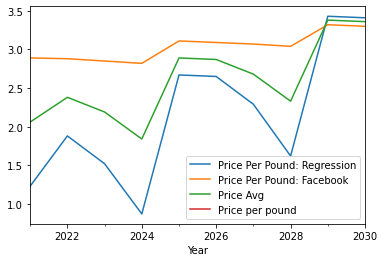

In [ ]:
compare_pred.plot()

In [ ]:
almonds.head()

,Production millon pounds,Price per pound,Revenue Total
Year,,,
2020-01-01,3115,1.83,5619930
2019-01-01,2560,2.45,6169100
2018-01-01,2280,2.50,5602500
2017-01-01,2270,2.53,5603950
2016-01-01,2140,2.39,5052460


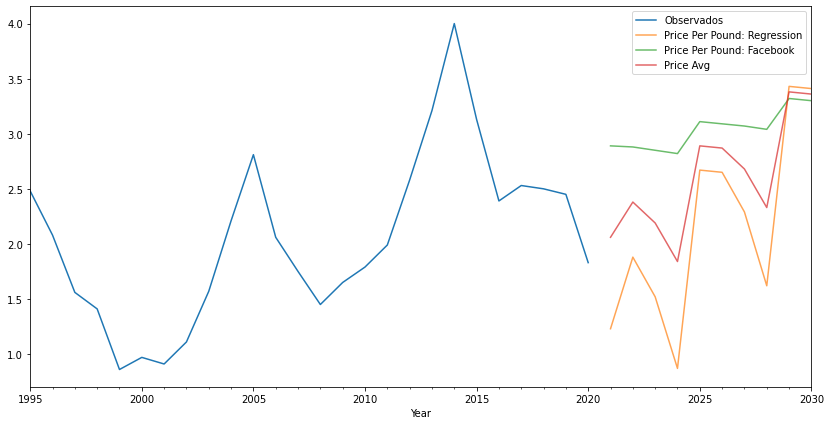

In [ ]:
ax = almonds['Price per pound'].plot(label='Observados')

compare_pred['Price Per Pound: Regression'].plot(ax=ax, label='Price Per Pound: Regression', alpha=0.7, figsize=(14, 7))
compare_pred['Price Per Pound: Facebook'].plot(ax=ax, label='Price Per Pound: Facebook', alpha=0.7, figsize=(14, 7))
compare_pred['Price Avg'].plot(ax=ax, label='Price Avg', alpha=0.7, figsize=(14, 7))


plt.legend()
plt.show()

In [ ]:
California_total.head()

,Year,Median Temperature Anomaly °C,Annual Average °C,CO2 Concentrations,Total Inches of Rainfall,Production millon pounds,Price per pound,Revenue Total,D0,D1,D2,D3,D4
0,2030-01-01,0.90,19.11,436.16,11.72,3449.62,3.30,9114914.56,153255.03,137683.95,106687.41,65892.66,29407.83
1,2029-01-01,0.89,19.32,433.82,12.38,3327.50,3.32,8918604.87,146302.62,131609.35,106012.29,63863.57,26635.40
2,2028-01-01,0.83,19.31,431.50,10.63,3375.94,3.04,8406925.03,156033.83,136852.63,95807.06,60182.19,29920.46
3,2027-01-01,0.83,19.10,429.19,11.35,3225.35,3.07,8245073.98,148507.88,130266.73,95215.42,58798.94,27580.51
4,2026-01-01,0.83,19.10,426.89,12.04,3088.96,3.09,8066043.31,141266.13,123934.72,94583.50,57093.07,25023.44


### Exporting

In [ ]:
#California_total.to_csv("/content/drive/MyDrive/Ironhack/Final_Project/Cali_Total.csv", index=False, encoding='utf-8-sig')

In [ ]:
compare_pred.reset_index(inplace=True)

In [ ]:
#compare_pred.to_csv("/content/drive/MyDrive/Ironhack/Final_Project/Almond_Predictions.csv", index=False, encoding='utf-8-sig')

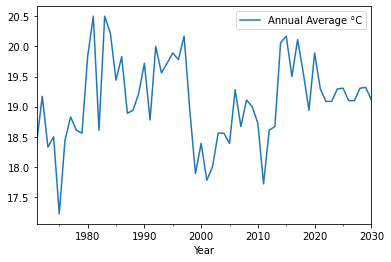

In [ ]:
california_temp_annual_Prediction.plot()

In [ ]:
california_temp_annual_Prediction.to_csv("/content/drive/MyDrive/Ironhack/Final_Project/california_Temp.csv", index=False, encoding='utf-8-sig')